<a href="https://colab.research.google.com/github/VitorFRodrigues/PUCMinas_DataScience/blob/main/03-Tec_Amostragem_Mod_regressao/Exercicios/TrabalhoFinal/TrabalhoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grupo 02

Instituição: Pontifícia Universidade Católica de Minas Gerais

Alunos:

* Alessandro Augusto Bezerra
* Robson Gomes de Lima
* Tiago Henrique Lacerda
* Vitor Fernando de Souza Rodrigues

Disciplina: Técnicas de Amostragem e Modelos de Regressão

Docente: Anaíle Mendes Rabelo

In [1]:
# Importação de bibliotecas usadas neste notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

## Exercício 1 - Determinar a probabilidade do usuário de comprar uma SUV, baseado em sua idade e salário. Utilizando a base de dados  SUV_Network_Ads.csv

### 1. Análise descritiva

Leitura inicial do dataframe

In [2]:
url = 'https://media.githubusercontent.com/media/VitorFRodrigues/PUCMinas_DataScience/main/03-Tec_Amostragem_Mod_regressao/Exercicios/TrabalhoFinal/quinto_andar_transformed_data.csv'
dados = pd.read_csv(url)
dados.head()

,url,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
0,https://www.quintoandar.com.br/imovel/89332996...,Liberdade,1900.0,424.0,5.0,25.0,38.0,2392.0,57.0,1.0,1.0,1.0,18.0,1.0,0.0,1.0
1,https://www.quintoandar.com.br/imovel/89334069...,Santa Cecília,1190.0,460.0,0.0,16.0,23.0,1689.0,56.0,1.0,1.0,0.0,11.0,1.0,1.0,1.0
2,https://www.quintoandar.com.br/imovel/89333859...,Aclimação,2330.0,450.0,5.0,30.0,46.0,2861.0,48.0,1.0,1.0,1.0,10.0,1.0,0.0,1.0
3,https://www.quintoandar.com.br/imovel/89337065...,Liberdade,1850.0,418.0,6.0,24.0,37.0,2335.0,44.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0
4,https://www.quintoandar.com.br/imovel/89337700...,Vila Guilherme,2200.0,392.0,10.0,28.0,44.0,2674.0,62.0,2.0,2.0,1.0,8.0,1.0,0.0,0.0


Ao ver o relatório informativo das colunas, vemos que todas as colunas são não-nulas, e apenas a coluna gênero é do tipo objeto.

In [ ]:
suv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


Vamos converter a coluna gênero para *int*, setando o valor 0 para masculino e 1 para feminino:

In [ ]:
suv["Gender"] = suv["Gender"].replace({"Male": 0, "Female": 1})

É possível analisar abaixo que os generos se encontram bem balanceados neste *dataset*.

In [ ]:
suv['Gender'].value_counts() / len(suv['Gender']) * 100

Gender
1    51.0
0    49.0
Name: count, dtype: float64

Abaixo temos a descrição das colunas. A exceção da coluna 'User ID', todas as demais podem ser declaradas para ingressar no modelo preditivo.  

In [ ]:
suv.describe()

,User ID,Gender,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000,400.000000
mean,1.569154e+07,0.510000,37.655000,69742.500000,0.357500
std,7.165832e+04,0.500526,10.482877,34096.960282,0.479864
min,1.556669e+07,0.000000,18.000000,15000.000000,0.000000
25%,1.562676e+07,0.000000,29.750000,43000.000000,0.000000
50%,1.569434e+07,1.000000,37.000000,70000.000000,0.000000
75%,1.575036e+07,1.000000,46.000000,88000.000000,1.000000
max,1.581524e+07,1.000000,60.000000,150000.000000,1.000000


Vamos analisar a correlação destas com a coluna saída 'Purchased' no mapa térmico abaixo.

<Axes: >

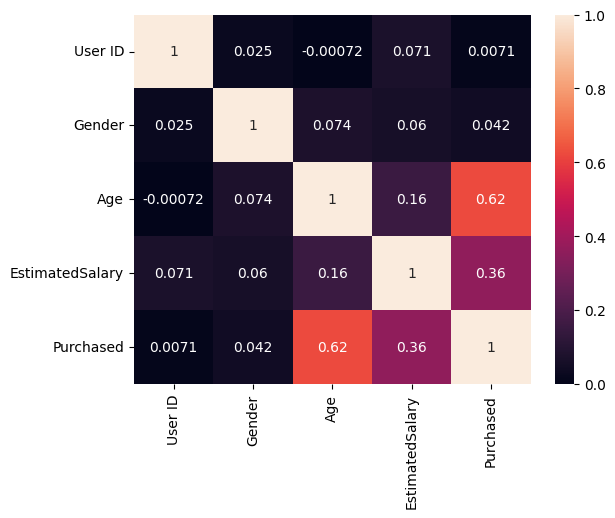

In [ ]:
# Mapa de correlação
corr = suv.corr()
sns.heatmap(corr, annot=True)

Vemos que a idade e o salário estimado possuem boa correlação.

### 2. Faça o modelo de regressão

Para esta questão, faremos 02 modelos de regressão logística, sendo:
* **Modelo 01**: Considerando todas as colunas como variavel independente, exceto a 'User ID'
* **Modelo 02**: Considerando apenas as colunas 'Age' e 'EstimatedSalary'


In [ ]:
lista_colunas = suv.drop('Purchased', axis=1).columns.to_list()[1:]
lista_colunas # Todas as variaveis para treino do modelo 1

['Gender', 'Age', 'EstimatedSalary']

In [ ]:
filtro_correlacao = 0.3
lista_selecionada = corr['Purchased'][corr['Purchased'].abs() > filtro_correlacao].sort_values(ascending=False).index.to_list()[1:]
lista_selecionada # Seleção de variáveis com boa correlação para treino do modelo 2

['Age', 'EstimatedSalary']

In [ ]:
# Definindo a variável dependente
y = suv['Purchased']  # Variável dependente

# Ajustando o modelo de regressão linear
modelo_1 = smf.glm(formula=f'{y.name} ~ {'+'.join(lista_colunas)}', data=suv, family = sm.families.Binomial()).fit()
modelo_2 = smf.glm(formula=f'{y.name} ~ {'+'.join(lista_selecionada)}', data=suv, family = sm.families.Binomial()).fit()
modelo_3 = smf.glm(formula=f'{y.name} ~ Age', data=suv, family = sm.families.Binomial()).fit()

# Sumário do modelo
modelos_summary = {"Modelo 1": modelo_1.summary(),
                   "Modelo 2": modelo_2.summary()}
modelos = {"Modelo 1": modelo_1,
           "Modelo 2": modelo_2}

### 3. Realize a análise dos pressupostos e validação do modelo

In [ ]:
for key, modelo in modelos_summary.items():
    print(key)
    print(modelo)

Modelo 1
                 Generalized Linear Model Regression Results                  
Dep. Variable:              Purchased   No. Observations:                  400
Model:                            GLM   Df Residuals:                      396
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -137.92
Date:                Tue, 09 Jul 2024   Deviance:                       275.84
Time:                        19:22:40   Pearson chi2:                     459.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4590
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -12.4498      1

Como visto anteriormente, a variável 'Gender' possui baixíssima correlação. Isto se reflete no p-value do modelo 01 que está acima de 0.05.

#### Deviance Residuals

**Hipótese Testada:**

-   $H_0$: O modelo ajusta bem os dados.

-   $H_a$: O modelo não ajusta bem os dados.

**Condição de Aceitação/Rejeição:**

-   A deviance total é comparada com uma distribuição qui-quadrado com $n - p$ graus de liberdade, onde $n$ é o número de observações e $p$ é o número de parâmetros no modelo.

-   **Aceitação de** $H_0$: Se o valor $p$ calculado a partir da deviance é maior que $\alpha$, aceitamos $H_0$ e concluímos que o modelo ajusta bem os dados.

-   **Rejeição de** $H_0$: Se o valor $p$ é menor que $\alpha$, rejeitamos $H_0$ e concluímos que o modelo não ajusta bem os dados.

In [ ]:
# Teste de Deviance para os Resíduos

for key, modelo in modelos.items():
    deviance_test_statistic = modelo.deviance
    deviance_df = modelo.df_resid
    deviance_p_value = 1 - stats.chi2.cdf(deviance_test_statistic, deviance_df)

    print(key)
    print("Teste de Deviance para os Resíduos:")
    print("Estatística de teste:", deviance_test_statistic)
    print("Graus de liberdade:", deviance_df)
    print("Valor p:", deviance_p_value)
    print('')

Modelo 1
Teste de Deviance para os Resíduos:
Estatística de teste: 275.84322537592294
Graus de liberdade: 396
Valor p: 0.9999990994573005

Modelo 2
Teste de Deviance para os Resíduos:
Estatística de teste: 277.05138239148346
Graus de liberdade: 397
Valor p: 0.9999990198090116



1. **Deviance Residuals**:
   - A deviance é uma medida da falta de ajuste de um modelo. Quanto menor o valor da deviance, melhor o modelo se ajusta aos dados.
   - O valor absoluto da deviance por si só não fornece uma imagem completa; ele deve ser interpretado em relação aos graus de liberdade.

2. **Graus de Liberdade Residuais**:
   - São uma medida da quantidade de dados disponíveis para estimar a variabilidade não explicada pelo modelo.
   - No seu caso, 396 graus de liberdade residuais indicam um número considerável de observações.

3. **Valor-p**:
   - O valor-p associado ao teste de deviance indica a probabilidade de observar uma deviance tão extrema (ou mais extrema) quanto a observada, assumindo que o modelo ajustado é correto.
   - Um valor-p alto (geralmente > 0.05) sugere que não há evidência suficiente para rejeitar o modelo ajustado; ou seja, o modelo é um ajuste adequado aos dados.

**Análise do Modelo** :

- **Deviance Residuals**: Com um valor de deviance de 275.84 (Modelo 1) ou 277.05 (Modelo 2) e 396 ou 397 graus de liberdade residuais, o valor da deviance não parece excessivamente grande. Isso sugere que o modelo pode estar capturando bem a variabilidade dos dados.
  
- **Valor-p**: O valor-p de 0.99 dado em ambos os modelos é extremamente alto. Isso indica que há uma alta probabilidade de que a deviance observada poderia ocorrer mesmo se o modelo ajustado for correto. Portanto, não há evidência para rejeitar o modelo com base na deviance residual.

**Conclusão:**

Com base nos valores fornecidos:
- O valor da deviance em relação aos graus de liberdade residuais não é excessivamente alto.
- O valor-p (0.99) sugere que não há evidência suficiente para rejeitar o modelo.

Portanto, podemos concluir que o modelo se ajusta bem aos dados. A deviance não é grande em relação aos graus de liberdade e o valor-p alto indica que a probabilidade de observar uma deviance tão extrema quanto a observada, dado que o modelo é correto, é muito alta. Assim, não temos razões para acreditar que o modelo não se ajusta bem aos dados.

#### Pearson Chi-Square Test

**Hipótese Testada:**

-   $H_0$: O modelo ajusta bem os dados.

-   $H_a$: O modelo não ajusta bem os dados.

**Condição de Aceitação/Rejeição:**

-   Calcula-se a estatística do teste qui-quadrado de Pearson, que segue uma distribuição qui-quadrado com $n - p$ graus de liberdade.

-   **Aceitação de** $H_0$: Se o valor $p$ é maior que $\alpha$, aceitamos $H_0$ e concluímos que o modelo ajusta bem os dados.

-   **Rejeição de** $H_0$: Se o valor $p$ é menor que $\alpha$, rejeitamos $H_0$ e concluímos que o modelo não ajusta bem os dados.

In [ ]:
for key, modelo in modelos.items():
    # Obtendo os resíduos de Pearson
    residuos_pearson = modelo.resid_pearson

    # Teste de Pearson para os Resíduos
    pearson_test_statistic = np.sum(residuos_pearson**2)
    pearson_df = len(residuos_pearson) - modelo.df_model - 1  # Graus de liberdade corrigidos
    pearson_p_value = 1 - stats.chi2.cdf(pearson_test_statistic, pearson_df)

    print(key)
    print("Teste de Pearson para os Resíduos:")
    print("Estatística de teste:", pearson_test_statistic)
    print("Graus de liberdade:", pearson_df)
    print("Valor p:", pearson_p_value, "\n")

Modelo 1
Teste de Pearson para os Resíduos:
Estatística de teste: 458.97202228971145
Graus de liberdade: 396
Valor p: 0.015686327881777706 

Modelo 2
Teste de Pearson para os Resíduos:
Estatística de teste: 466.77640978752015
Graus de liberdade: 397
Valor p: 0.008947131735509428 



O Pearson Chi-Square Test (teste qui-quadrado de Pearson) é outra metodologia para avaliar o ajuste de um modelo. Aqui, consideramos a estatística de teste, os graus de liberdade e o valor-p para determinar a adequação do modelo.

**Interpretação do Pearson Chi-Square Test:**

1. **Estatística de Teste (Pearson Chi-Square)**:
   - A estatística de teste do qui-quadrado compara os resíduos observados com os resíduos esperados sob o modelo ajustado.
   - Valores maiores indicam maior discrepância entre os dados observados e os esperados.

2. **Graus de Liberdade**:
   - São uma medida do número de valores independentes que entram no cálculo da estatística.
   - Neste caso, 396 e 397 graus de liberdade sugerem um número substancial de observações.

3. **Valor-p**:
   - O valor-p indica a probabilidade de observar uma estatística de teste tão extrema quanto a observada, assumindo que o modelo ajustado é correto.
   - Um valor-p baixo (geralmente < 0.05) sugere que há evidência suficiente para rejeitar o modelo ajustado; ou seja, o modelo pode não ser um bom ajuste aos dados.

**Análise do Modelo com Pearson Chi-Square Test:**

- **Estatística de Teste**: Com um valor de 458.972 (Modelo 1) ou 466.776 (Modelo 2), a estatística de teste é relativamente alta em comparação com os graus de liberdade 396 (Modelo 1) ou 397 (Modelo 2).
  
- **Valor-p**: O valor-p de 0.015686 (Modelo 1) e 0.008 (Modelo 2) são menores que 0.05, indicando que há uma baixa probabilidade de observar uma estatística de teste tão extrema quanto a observada se o modelo ajustado fosse correto. Isso sugere que há evidência para rejeitar o modelo ajustado.

**Conclusão:**

Com base nos valores fornecidos para o Pearson Chi-Square Test:
- A estatística de teste é maior que os graus de liberdade, o que indica uma discrepância significativa entre os resíduos observados e os esperados.
- O valor-p é menor que 0.05, sugerindo que há evidência suficiente para rejeitar o modelo ajustado.

Portanto, considerando o Pearson Chi-Square Test, podemos concluir que o modelo pode não se ajustar bem aos dados. O valor-p baixo indica que a discrepância entre os dados observados e os esperados sob o modelo ajustado é significativa, sugerindo que o modelo pode não ser um ajuste adequado para os dados.

#### Teste de Hosmer-Lemeshow

**Hipótese Testada:**

-   $H_0$: O modelo ajusta bem os dados (não há diferença significativa entre as frequências observadas e esperadas).

-   $H_a$: O modelo não ajusta bem os dados (há diferença significativa entre as frequências observadas e esperadas).

**Condição de Aceitação/Rejeição:**

-   Calcula-se a estatística do teste de Hosmer-Lemeshow, que segue uma distribuição qui-quadrado com $g - 2$ graus de liberdade, onde $g$ é o número de grupos.

-   **Aceitação de** $H_0$: Se o valor $p$ é maior que o nível de significância $\alpha$ (geralmente 0.05), aceitamos $H_0$ e concluímos que o modelo ajusta bem os dados.

-   **Rejeição de** $H_0$: Se o valor $p$ é menor que $\alpha$, rejeitamos $H_0$ e concluímos que o modelo não ajusta bem os dados.

In [ ]:
def hosmer_lemeshow_test(model, g=10):
    data = pd.DataFrame({'observed': model.model.endog, 'predicted': model.fittedvalues})
    data['group'] = pd.qcut(data['predicted'], g, duplicates='drop')
    grouped = data.groupby('group')
    observed = grouped['observed'].sum()
    expected = grouped['predicted'].sum()
    hl_stat = ((observed - expected) ** 2 / (expected * (1 - expected / grouped.size()))).sum()
    hl_p_value = stats.chi2.sf(hl_stat, g - 2)
    return hl_stat, hl_p_value

for key, modelo in modelos.items():
    hl_stat, hl_p_value = hosmer_lemeshow_test(modelo)
    print(key)
    print(f"Hosmer-Lemeshow Test: \nStat={hl_stat}, \np-value={hl_p_value}\n")

Modelo 1
Hosmer-Lemeshow Test: 
Stat=22.843640132104508, 
p-value=0.003570902818614943

Modelo 2
Hosmer-Lemeshow Test: 
Stat=32.08079753596097, 
p-value=9.008841056301578e-05



O Teste de Hosmer-Lemeshow é outra metodologia usada para avaliar o ajuste de um modelo, especialmente em regressão logística. Vamos analisar os resultados fornecidos:

1. **Estatística de Hosmer-Lemeshow**:
   - A estatística de Hosmer-Lemeshow é uma medida de quão bem os dados observados se ajustam aos dados esperados sob o modelo.
   - Valores mais altos da estatística indicam uma maior discrepância entre os valores observados e esperados.

2. **Valor-p**:
   - O valor-p indica a probabilidade de observar uma estatística de teste tão extrema quanto a observada, assumindo que o modelo ajustado é correto.
   - Um valor-p baixo (geralmente < 0.05) sugere que há evidência suficiente para rejeitar o modelo ajustado; ou seja, o modelo pode não ser um bom ajuste aos dados.

**Análise do Modelo com o Teste de Hosmer-Lemeshow:**

- **Estatística de Teste**: Com um valor de 22.84 (Modelo 1) e 32.08 (Modelo 2), a estatística de Hosmer-Lemeshow é relativamente alta.
  
- **Valor-p**: O valor-p de 0.003 (Modelo 1) e 0.00009 (Modelo 2) é menor que 0.05, indicando que há uma baixa probabilidade de observar uma estatística de teste tão extrema quanto a observada se o modelo ajustado fosse correto. Isso sugere que há evidência para rejeitar o modelo ajustado.

**Conclusão:**

Com base nos valores fornecidos para o Teste de Hosmer-Lemeshow:
- A estatística de teste alta indica uma discrepância significativa entre os valores observados e esperados.
- O valor-p é menor que 0.05, sugerindo que há evidência suficiente para rejeitar o modelo ajustado.

Portanto, considerando o Teste de Hosmer-Lemeshow, podemos concluir que o modelo pode não se ajustar bem aos dados. O valor-p baixo indica que a discrepância entre os dados observados e os esperados sob o modelo ajustado é significativa, sugerindo que o modelo pode não ser um ajuste adequado para os dados.

#### ROC Curve and AUC

Avalia a capacidade do modelo de discriminar entre as classes.

**Curva ROC**: Traça a taxa de verdadeiros positivos (sensibilidade) contra a taxa de falsos positivos (1 - especificidade) para vários limiares de classificação.

**AUC (Área Sob a Curva)**: Um valor próximo de 1 indica excelente discriminação, enquanto um valor próximo de 0.5 indica discriminação aleatória. -

**Avaliação do Modelo**: Um modelo com AUC maior é considerado melhor em discriminar entre as classes.

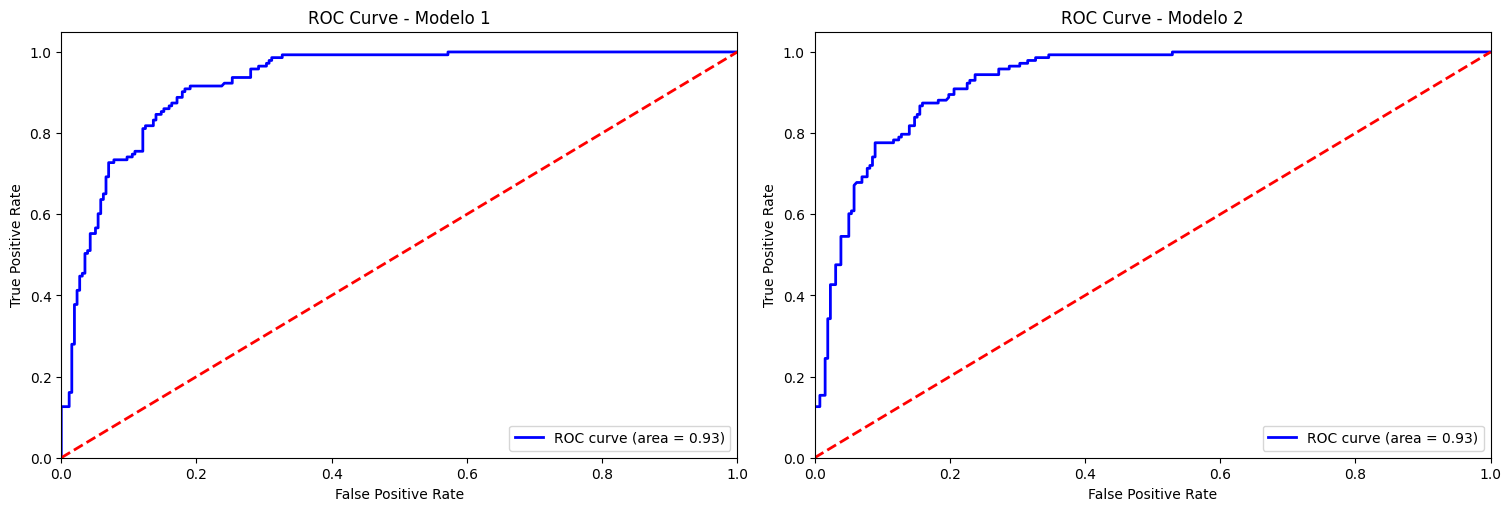

In [ ]:
# Determinando o número de modelos para definir o layout da subplot
num_modelos = len(modelos)

# Criando subplots
fig, axs = plt.subplots(1, num_modelos, figsize=(15, 5), constrained_layout=True)

# Iterando sobre cada modelo para plotar a curva ROC
for ax, (key, modelo) in zip(axs, modelos.items()):
    fpr, tpr, _ = roc_curve(y, modelo.fittedvalues)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {key}')
    ax.legend(loc="lower right")

# Mostrar todos os plots
plt.show()

Ambos os modelos têm um desempenho muito bom na distinção entre classes, com uma AUC de 0.93. Isso indica que ambos os modelos têm uma alta precisão em distinguir entre classes positivas e negativas, e que são igualmente eficazes com base na métrica AUC.

### 4. Análise do Modelo

1. **Deviance Residuals**: Indicou um bom ajuste do modelo.
2. **Pearson Chi-Square Test**: Indicou um ajuste inadequado do modelo.
3. **Teste de Hosmer-Lemeshow**: Indicou um ajuste inadequado do modelo.
4. **ROC curve and AUC**: Indicou um bom ajuste do modelo.

Com base nas quatro metodologias de avaliação, parece haver uma discrepância nas conclusões. Dois dos testes (Pearson Chi-Square e Hosmer-Lemeshow) sugerem que o modelo não se ajusta bem aos dados, enquanto o teste dos Deviance Residuals e curva ROC sugere o contrário. Em casos como este, é importante considerar ajustes adicionais no modelo e/ou explorar outras métricas de avaliação para obter uma compreensão mais completa do ajuste do modelo aos dados.

### 5. Interpretação do ODDS

Iremos utilizar o que chamamos como razão de chance com Intervalo de confiança de 95%:
- exponencial do coeficiente.

In [ ]:
for key, modelo in modelos.items():
    print(key)
    for col, const in modelo.params.items():
        if col != 'Intercept':
            print(f'{col}: ODDS = {np.exp(const)}')
    print('')

Modelo 1
Gender: ODDS = 0.7161659334343544
Age: ODDS = 1.2674023356162754
EstimatedSalary: ODDS = 1.0000364418543706

Modelo 2
Age: ODDS = 1.2629994932016952
EstimatedSalary: ODDS = 1.0000359015826144



#### Modelo 1:

* **Gender**: O odds ratio para o gênero indica que ser mulher ('Female'=1) está associado a uma redução de aproximadamente 28,38% (1 - 0.716) nas odds do evento de interesse em comparação com ser homem ('Male'=0). Em outras palavras, se todas as outras variáveis forem mantidas constantes, ser mulher diminui as chances do evento ocorrer;

* **Age**: Cada unidade adicional na idade está associada a um aumento de aproximadamente 26.74% (1.267 - 1) nas odds do evento de interesse. Isso sugere que pessoas mais velhas têm uma maior probabilidade do evento ocorrer, se todas as outras variáveis forem mantidas constantes;

* **EstimatedSalary**: Cada unidade adicional no salário estimado está associada a um aumento minúsculo nas odds do evento de interesse. O impacto é muito pequeno, mas é positivo, sugerindo que um salário estimado maior aumenta ligeiramente as chances do evento ocorrer;

#### Modelo 2:

* **Age**: Cada unidade adicional na idade está associada a um aumento de aproximadamente 26.30% (1.263 - 1) nas odds do evento de interesse. Isso é consistente com a interpretação do Modelo 1;

* **EstimatedSalary**: Cada unidade adicional no salário estimado está associada a um aumento muito pequeno nas odds do evento de interesse. Este impacto é também muito pequeno e positivo, similar ao Modelo 1;

#### Comparação entre os Modelos

* **Age**: Ambos os modelos mostram um aumento muito similar nas odds associadas à idade (aproximadamente 26.74% no Modelo 1 e 26.30% no Modelo 2). Isso sugere que a idade é um preditor consistente e significativo do evento de interesse em ambos os modelos.

* **EstimatedSalary**: Ambos os modelos mostram um aumento muito pequeno e praticamente idêntico nas odds associadas ao salário estimado, sugerindo que essa variável tem um impacto muito pequeno, mas positivo.

* **Gender (apenas no Modelo 1)**: O Modelo 1 inclui a variável gênero, que não está presente no Modelo 2. O odds ratio associado ao gênero indica que ser mulher está associado a uma menor probabilidade do evento ocorrer. A ausência desta variável no Modelo 2 significa que o Modelo 2 não está considerando possíveis diferenças entre homens e mulheres.

#### Conclusão

* **Modelo 1:** Inclui uma variável adicional (gênero) que parece ser significativa e afeta as odds do evento de interesse. Se o gênero é uma variável importante para o contexto do estudo, o Modelo 1 pode ser mais adequado.

* **Modelo 2:** Foca apenas em idade e salário estimado, mostrando resultados consistentes para essas variáveis em comparação com o Modelo 1. Se o gênero não é relevante ou disponível, o Modelo 2 é uma alternativa simplificada.

A escolha entre os modelos deve ser baseada no contexto do estudo e na disponibilidade de dados. O Modelo 1 pode ser preferível se o gênero é uma variável importante, enquanto o Modelo 2 pode ser suficiente se o foco está apenas em idade e salário estimado.

## Exercício 2 – Faça um regressão multinominal utilizando a base dados_lista_2_multinominal-1.csv

Determine o impacto das variáveis ses e write, no tipo de programa (prog) dos alunos da base. (prog ~ses + wrie)

Faça uma análise detalhada os odds em relação a probabilidade de cada tipo de programa, considerando todos os níveis.  

### 1. Análise descritiva

Leitura inicial do dataframe

In [ ]:
dados = pd.read_csv('dados_lista_2_multinominal-1.csv')
dados.head()

,Unnamed: 0,id,female,ses,schtyp,prog,read,write,math,science,socst,honors,awards,cid
0,1,45,female,low,public,vocation,34,35,41,29,26,not enrolled,0,1
1,2,108,male,middle,public,general,34,33,41,36,36,not enrolled,0,1
2,3,15,male,high,public,vocation,39,39,44,26,42,not enrolled,0,1
3,4,67,male,low,public,vocation,37,37,42,33,32,not enrolled,0,1
4,5,153,male,middle,public,vocation,39,31,40,39,51,not enrolled,0,1


Ao ver o relatório informativo das colunas, vemos que todas as colunas são não-nulas, e as seguintes colunas são do tipo 'object':
* female -> será renomeado posteriormente para 'Gender' para melhor sentido.
* ses
* schtyp
* prog
* honors

In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  200 non-null    int64 
 1   id          200 non-null    int64 
 2   female      200 non-null    object
 3   ses         200 non-null    object
 4   schtyp      200 non-null    object
 5   prog        200 non-null    object
 6   read        200 non-null    int64 
 7   write       200 non-null    int64 
 8   math        200 non-null    int64 
 9   science     200 non-null    int64 
 10  socst       200 non-null    int64 
 11  honors      200 non-null    object
 12  awards      200 non-null    int64 
 13  cid         200 non-null    int64 
dtypes: int64(9), object(5)
memory usage: 22.0+ KB


In [ ]:
dados.rename(columns={'female': 'gender'},inplace=True, errors='raise')

Vamos analisar os valores únicos de cada coluna object para transforma-las em colunas numéricas.

In [ ]:
col_cat = ['gender', 'ses', 'schtyp', 'prog', 'honors']
for col in col_cat:
    print(f'{col}: {dados[col].unique()}')

gender: ['female' 'male']
ses: ['low' 'middle' 'high']
schtyp: ['public' 'private']
prog: ['vocation' 'general' 'academic']
honors: ['not enrolled' 'enrolled']


Para resolver a questão, nosso interesse será focado em tratar as colunas 'ses', 'write' e 'prog'. Porém, antes de iniciar as análises, vamos categorizar as colunas para fazer um mapa de calor de correlação. Vamos categorizar conforme tabela abaixo:
| gender | gender_cat | ses    | ses_cat | schtyp  | schtyp_cat | prog     | prog_cat | honors       | honors_cat |
|--------|------------|--------|---------|---------|------------|----------|----------|--------------|------------|
| female | 0          | low    | 0       | public  | 0          | vocation | 0        | not enrolled | 0          |
| male   | 1          | middle | 1       | private | 1          | general  | 1        | enrolled     | 1          |
| -      | -          | high   | 2       | -       | -          | academic | 2        | -            | -          |

A coluna 'prog' por se tratar da resposta do modelo multinomial, pode conter mais de 2 variáveis com valores distintos em mesma coluna. No entando a coluna 'ses' necessita ser desmembrada em mais colunas para representar as variaveis 'low', 'middle' e 'high' de maneira igualitária de modo que o modelo não imponha peso em uma destas.

In [ ]:
df_dummies = pd.get_dummies(dados['ses'], drop_first=True, dtype=int)
df_dummies.rename(columns={'low': 'ses_low',
                           'middle': 'ses_middle'},inplace=True, errors='raise')
dados = pd.concat([dados, df_dummies], axis=1)
dados.drop(columns=['ses'], inplace=True)

Agora vamos tornar demais variáveis em categóricas.

In [ ]:
col_cat = ['gender', 'schtyp', 'prog', 'honors']
i = 0
for col in col_cat:
    col_unica = dados[col].unique()
    for i in range(0, len(col_unica)):
        dados[col] = dados[col].replace({col_unica[i]: i})
for col in col_cat:
    print(f'{col}: {dados[col].unique()}')

gender: [0 1]
schtyp: [0 1]
prog: [0 1 2]
honors: [0 1]


Abaixo temos a descrição das colunas. Todas as demais podem ser declaradas para ingressar no modelo preditivo.  

In [ ]:
dados.describe()

,Unnamed: 0,id,gender,schtyp,prog,read,write,math,science,socst,honors,awards,cid,ses_low,ses_middle
count,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,100.500000,0.45500,0.160000,1.275000,52.230000,52.775000,52.645000,51.850000,52.405000,0.265000,1.670000,10.430000,0.235000,0.475000
std,57.879185,57.879185,0.49922,0.367526,0.838385,10.252937,9.478586,9.368448,9.900891,10.735793,0.442441,1.818691,5.801152,0.425063,0.500628
min,1.000000,1.000000,0.00000,0.000000,0.000000,28.000000,31.000000,33.000000,26.000000,26.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,50.750000,50.750000,0.00000,0.000000,0.750000,44.000000,45.750000,45.000000,44.000000,46.000000,0.000000,0.000000,5.000000,0.000000,0.000000
50%,100.500000,100.500000,0.00000,0.000000,2.000000,50.000000,54.000000,52.000000,53.000000,52.000000,0.000000,1.000000,10.500000,0.000000,0.000000
75%,150.250000,150.250000,1.00000,0.000000,2.000000,60.000000,60.000000,59.000000,58.000000,61.000000,1.000000,2.000000,15.000000,0.000000,1.000000
max,200.000000,200.000000,1.00000,1.000000,2.000000,76.000000,67.000000,75.000000,74.000000,71.000000,1.000000,7.000000,20.000000,1.000000,1.000000


Como 'prog' será nossa variavel output, vamos move-la para o final do dataframe.

In [ ]:
last_column = dados.pop('prog')
dados.insert(len(dados.columns), 'prog', last_column)
dados.head()

,Unnamed: 0,id,gender,schtyp,read,write,math,science,socst,honors,awards,cid,ses_low,ses_middle,prog
0,1,45,0,0,34,35,41,29,26,0,0,1,1,0,0
1,2,108,1,0,34,33,41,36,36,0,0,1,0,1,1
2,3,15,1,0,39,39,44,26,42,0,0,1,0,0,0
3,4,67,1,0,37,37,42,33,32,0,0,1,1,0,0
4,5,153,1,0,39,31,40,39,51,0,0,1,0,1,0


Vamos analisar a correlação destas com a coluna saída 'Prog' no mapa térmico abaixo.

<Axes: >

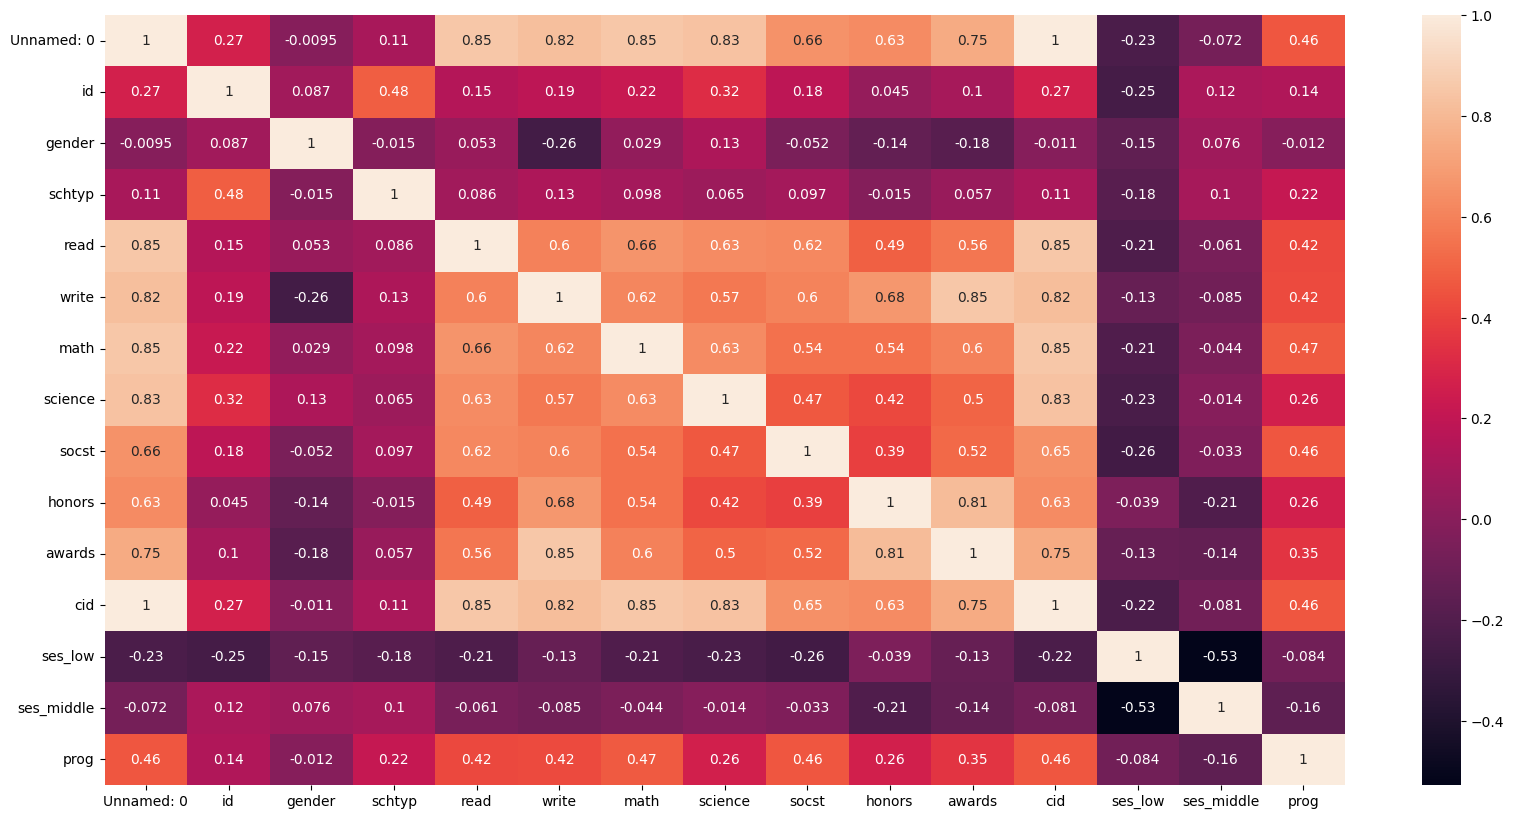

In [ ]:
# Mapa de correlação
plt.figure(figsize=(20,10))
corr = dados.corr()
sns.heatmap(corr, annot=True)

Vemos que as colunas de interesse possuem as seguintes correlações com 'prog':
* ses_low: 0.084
* ses_middle: 0.16
* write: 0.42

### 2. Faça o modelo de regressão

Para esta questão, faremos o seguinte modelos de regressão multinomial:
* **Entradas**: 'ses_low', 'ses_middle' e 'write'
* **Saídas**: 'prog'

In [ ]:
y = dados['prog']
X = dados[['ses_low', 'ses_middle', 'write']]

Vamos agora dividir os dados em conjuntos de treinamento e teste.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Verificar o tamanho de cada conjunto de dados

In [ ]:
print("Tamanho do conjunto de treinamento (X_train):", X_train.shape)
print("Tamanho do conjunto de teste (X_test):", X_test.shape)
print("Tamanho do conjunto de treinamento (y_train):", y_train.shape)
print("Tamanho do conjunto de teste (y_test):", y_test.shape)

Tamanho do conjunto de treinamento (X_train): (160, 3)
Tamanho do conjunto de teste (X_test): (40, 3)
Tamanho do conjunto de treinamento (y_train): (160,)
Tamanho do conjunto de teste (y_test): (40,)


In [ ]:
# Ajustar o modelo de regressão logística multinomial usando statsmodels
model = sm.MNLogit(y_train, sm.add_constant(X_train))
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.891390
         Iterations 6


### 3. Realize a análise dos pressupostos e validação do modelo

Resumo do modelo treinado:

In [ ]:
print(results.summary())

                          MNLogit Regression Results                          
Dep. Variable:                   prog   No. Observations:                  160
Model:                        MNLogit   Df Residuals:                      152
Method:                           MLE   Df Model:                            6
Date:                Tue, 09 Jul 2024   Pseudo R-squ.:                  0.1145
Time:                        19:22:42   Log-Likelihood:                -142.62
converged:                       True   LL-Null:                       -161.07
Covariance Type:            nonrobust   LLR p-value:                 1.849e-06
    prog=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6629      1.403     -1.898      0.058      -5.413       0.087
ses_low       -0.2798      0.724     -0.387      0.699      -1.698       1.138
ses_middle    -0.7385      0.647     -1.142      0.2

Analisando apenas o sumario dos resultados temos que a variável 'write' é um preditor significativo da categoria 'prog', enquanto 'ses_low' e 'ses_middle' não parece ter um impacto significativo. O modelo geral é significativo, indicando um bom ajuste aos dados.

In [ ]:
# Obter probabilidades previstas
probabilidades_previstas = results.predict()

#### Deviance Residuals

**Hipótese Testada:**

-   $H_0$: O modelo ajusta bem os dados.

-   $H_a$: O modelo não ajusta bem os dados.

**Condição de Aceitação/Rejeição:**

-   A deviance total é comparada com uma distribuição qui-quadrado com $n - p$ graus de liberdade, onde $n$ é o número de observações e $p$ é o número de parâmetros no modelo.

-   **Aceitação de** $H_0$: Se o valor $p$ calculado a partir da deviance é maior que $\alpha$, aceitamos $H_0$ e concluímos que o modelo ajusta bem os dados.

-   **Rejeição de** $H_0$: Se o valor $p$ é menor que $\alpha$, rejeitamos $H_0$ e concluímos que o modelo não ajusta bem os dados.

In [ ]:
# Resíduos: calcular resíduos deviance manualmente
def residuos_deviance(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1-1e-10)  # Evitar log(0)
    deviance_residuals = 2 * (y_true * np.log(y_true / y_pred))
    deviance_residuals[np.isnan(deviance_residuals)] = 0  # Substituir NaNs por 0
    return deviance_residuals

In [ ]:
# One-hot encoding para y_train
y_train_onehot = pd.get_dummies(y_train).values

In [ ]:
# Calcular resíduos deviance
residuos_deviance_val = residuos_deviance(y_train_onehot, probabilidades_previstas)

In [ ]:
# Deviance total e p-valor
deviance_total = np.sum(residuos_deviance_val)
deviance_p_value = stats.chi2.sf(deviance_total, results.df_resid)
print(f"Deviance: {deviance_total}, p-value: {deviance_p_value}")

Deviance: 285.24476020345196, p-value: 3.521875447474953e-10


**Análise do Modelo** :

- **Deviance Residuals**: A deviance de 285.244 indica a qualidade do ajuste do modelo. Quanto menor for o valor da deviance, melhor o modelo ajusta os dados. Sozinho, esse valor não pode ser interpretado diretamente sem um valor de referência, mas geralmente, a deviance é comparada com um modelo saturado para verificar o ajuste.
  
- **Valor-p**: O p-value associado à deviance é utilizado para testar a hipótese nula de que o modelo ajusta bem os dados. Um p-value pequeno (geralmente menor que 0.05) indica que há evidências suficientes para rejeitar a hipótese nula, ou seja, o modelo não se ajusta bem aos dados.

**Conclusão:**

Com base na deviance e no p-value, o modelo multinomial não se ajusta bem aos dados. A deviance alta e o p-value muito pequeno indicam que há uma discrepância significativa entre os dados observados e os valores ajustados pelo modelo.

#### Pearson Chi-Square Test

**Hipótese Testada:**

-   $H_0$: O modelo ajusta bem os dados.

-   $H_a$: O modelo não ajusta bem os dados.

**Condição de Aceitação/Rejeição:**

-   Calcula-se a estatística do teste qui-quadrado de Pearson, que segue uma distribuição qui-quadrado com $n - p$ graus de liberdade.

-   **Aceitação de** $H_0$: Se o valor $p$ é maior que $\alpha$, aceitamos $H_0$ e concluímos que o modelo ajusta bem os dados.

-   **Rejeição de** $H_0$: Se o valor $p$ é menor que $\alpha$, rejeitamos $H_0$ e concluímos que o modelo não ajusta bem os dados.

In [ ]:
# Pearson Chi-Square Test
def residuos_pearson(y_true, y_pred):
    return (y_true - y_pred) / np.sqrt(y_pred * (1 - y_pred))

In [ ]:
residuos_pearson_val = residuos_pearson(y_train_onehot, probabilidades_previstas)
pearson_chi2 = np.sum(residuos_pearson_val ** 2)
pearson_p_value = stats.chi2.sf(pearson_chi2, results.df_resid)
print(f"Pearson Chi-Square Test: Chi2={pearson_chi2}, p-value={pearson_p_value}")

Pearson Chi-Square Test: Chi2=492.20346390164065, p-value=1.6410868567699196e-37


**Análise do Modelo com Pearson Chi-Square Test:**

- **Estatística de Teste**: O valor do Chi-Square é 492.203. Um valor de Chi-Square alto indica uma grande discrepância entre os valores observados e os valores esperados sob o modelo.
  
- **Valor-p**: O p-value é extremamente pequeno, o que sugere que o modelo não se ajusta bem aos dados.
Com um p-value tão pequeno, rejeitamos a hipótese nula de que o modelo ajusta bem os dados. Isso indica que há uma falta de ajuste significativa no modelo.

**Conclusão:**

Esses resultados corroboram a análise anterior baseada nos deviance residuals, indicando que o modelo multinomial não se ajusta bem aos dados.

#### Teste de Hosmer-Lemeshow

**Hipótese Testada:**

-   $H_0$: O modelo ajusta bem os dados (não há diferença significativa entre as frequências observadas e esperadas).

-   $H_a$: O modelo não ajusta bem os dados (há diferença significativa entre as frequências observadas e esperadas).

**Condição de Aceitação/Rejeição:**

-   Calcula-se a estatística do teste de Hosmer-Lemeshow, que segue uma distribuição qui-quadrado com $g - 2$ graus de liberdade, onde $g$ é o número de grupos.

-   **Aceitação de** $H_0$: Se o valor $p$ é maior que o nível de significância $\alpha$ (geralmente 0.05), aceitamos $H_0$ e concluímos que o modelo ajusta bem os dados.

-   **Rejeição de** $H_0$: Se o valor $p$ é menor que $\alpha$, rejeitamos $H_0$ e concluímos que o modelo não ajusta bem os dados.

In [ ]:
# Teste de Hosmer-Lemeshow
def hosmer_lemeshow_test(y_true, y_pred, g=10):
    data = pd.DataFrame({'observed': np.argmax(y_true, axis=1), 'predicted': np.max(y_pred, axis=1)})
    data['group'] = pd.qcut(data['predicted'], g, duplicates='drop')
    grouped = data.groupby('group')
    observed = grouped['observed'].sum()
    expected = grouped['predicted'].sum()
    hl_stat = ((observed - expected) ** 2 / (expected * (1 - expected / grouped.size()))).sum()
    hl_p_value = stats.chi2.sf(hl_stat, g - 2)
    return hl_stat, hl_p_value

In [ ]:
hl_stat, hl_p_value = hosmer_lemeshow_test(y_train_onehot, probabilidades_previstas)
print(f"Hosmer-Lemeshow Test: Stat={hl_stat}, p-value={hl_p_value}")

Hosmer-Lemeshow Test: Stat=409.38423346734896, p-value=1.8402456439587498e-83


**Análise do Modelo com o Teste de Hosmer-Lemeshow:**

- **Estatística de Teste**: Um valor tão alto indica uma grande discrepância entre os valores observados e os valores esperados sob o modelo.
  
- **Valor-p**: sugere que o modelo não se ajusta bem aos dados. Com um p-value tão pequeno, rejeitamos a hipótese nula de que o modelo ajusta bem os dados. Isso indica que há uma falta de ajuste significativa no modelo.

**Conclusão:**

Esses resultados, juntamente com as análises anteriores (deviance residuals e Pearson Chi-Square Test), indicam que o modelo multinomial (MNLogit) não se ajusta bem aos dados.

#### Razão de Verossimilhança (LR)

In [ ]:
import scipy.stats as stats

# Calcular o valor p para o teste de Razão de Verossimilhança (LR)
lrt_test_statistic = results.llr  # Obtém o valor do teste de Likelihood Ratio
lrt_df = results.df_model  # Obtém os graus de liberdade do modelo
lrt_p_value = 1 - stats.chi2.cdf(lrt_test_statistic, lrt_df)

print("\nTeste de Razão de Verossimilhança (LR) para os Resíduos:")
print(f"Estatística de teste: {lrt_test_statistic}")
print(f"Graus de liberdade: {lrt_df}")
print(f"Valor p: {lrt_p_value}")


Teste de Razão de Verossimilhança (LR) para os Resíduos:
Estatística de teste: 36.89178002817778
Graus de liberdade: 6.0
Valor p: 1.848520985947566e-06


**Análise do Modelo com o Razão de Verossimilhança (LR):**

- **Estatística de Teste**: Valores altos indicam que o modelo completo fornece um ajuste significativamente melhor do que o modelo reduzido.

- **Graus de liberdade**: Os graus de liberdade são 6, correspondendo à diferença no número de parâmetros entre os dois modelos.

- **Valor-p**: é extremamente pequeno. Um p-value pequeno sugere que a hipótese nula (o modelo reduzido é adequado) pode ser rejeitada em favor da hipótese alternativa (o modelo completo oferece um ajuste significativamente melhor).

**Conclusão:**

Esses resultados indicam que o modelo multinomial (MNLogit) completo se ajusta melhor aos dados do que um modelo reduzido (possivelmente com menos parâmetros).

#### ROC Curve and AUC

Avalia a capacidade do modelo de discriminar entre as classes.

**Curva ROC**: Traça a taxa de verdadeiros positivos (sensibilidade) contra a taxa de falsos positivos (1 - especificidade) para vários limiares de classificação.

**AUC (Área Sob a Curva)**: Um valor próximo de 1 indica excelente discriminação, enquanto um valor próximo de 0.5 indica discriminação aleatória. -

**Avaliação do Modelo**: Um modelo com AUC maior é considerado melhor em discriminar entre as classes.

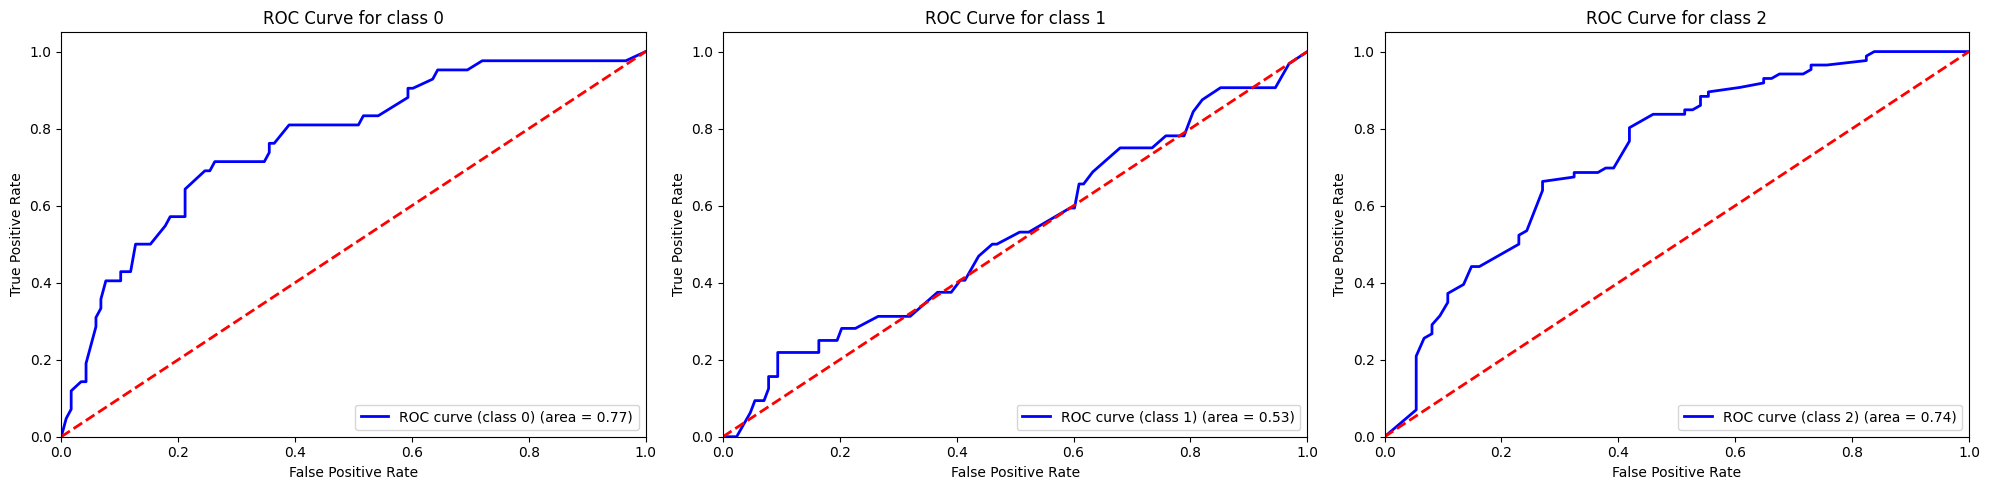

In [ ]:
# Número de classes
num_classes = y_train_onehot.shape[1]

# Criar subplots
fig, axs = plt.subplots(1, num_classes, figsize=(20, 5))

# Curva ROC para cada classe
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_train_onehot[:, i], probabilidades_previstas[:, i])
    roc_auc = auc(fpr, tpr)

    axs[i].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (class {i}) (area = %0.2f)' % roc_auc)
    axs[i].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    axs[i].set_xlim([0.0, 1.0])
    axs[i].set_ylim([0.0, 1.05])
    axs[i].set_xlabel('False Positive Rate')
    axs[i].set_ylabel('True Positive Rate')
    axs[i].set_title(f'ROC Curve for class {i}')
    axs[i].legend(loc="lower right")

# Ajustar o layout
plt.tight_layout()
plt.show()

* **Classe 0** e **Classe 2** têm AUCs de 0.77 e 0.74, respectivamente. Esses valores indicam que o modelo tem um desempenho razoável para essas classes, mas há espaço para melhorias.

* **Classe 1** tem uma AUC de 0.53, o que sugere que o modelo tem pouca capacidade de discriminação para essa classe. Isso é preocupante e pode indicar que os dados ou o modelo precisam ser ajustados para melhorar o desempenho para essa classe.

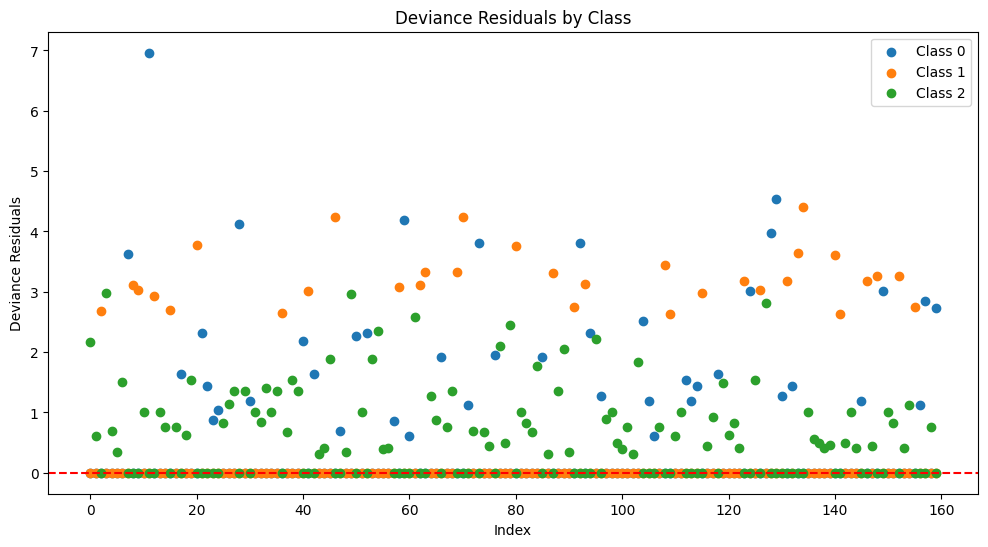

In [ ]:
# Plotar resíduos deviance
plt.figure(figsize=(12, 6))
for i in range(residuos_deviance_val.shape[1]):
    plt.scatter(range(len(residuos_deviance_val)), residuos_deviance_val[:, i], label=f'Class {i}')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Deviance Residuals')
plt.title('Deviance Residuals by Class')
plt.legend()
plt.show()

1. **Distribuição de Resíduos**:
   - A maioria dos resíduos está distribuída em torno de zero, o que é esperado e indica que, para muitas observações, o modelo está prevendo valores próximos aos valores observados.
   - No entanto, há vários pontos com resíduos deviance elevados (acima de 3), o que sugere que o modelo não está se ajustando bem para essas observações específicas.

2. **Outliers**:
   - Existem vários outliers (pontos fora do padrão esperado) para todas as classes, especialmente acima de 3, indicando que para essas observações específicas, o modelo não está capturando bem a variabilidade dos dados.
   - Notamos outliers significativos em todas as classes, mas especialmente em Classes 0 e 1. Esses outliers podem ser causados por erros nos dados, variáveis importantes não incluídas no modelo ou uma inadequação geral do modelo para essas observações.

3. **Classes**:
   - **Classe 0 (Azul)**: Existem vários resíduos acima de 3, indicando que o modelo tem dificuldades em prever corretamente essa classe em alguns casos.
   - **Classe 1 (Laranja)**: Também apresenta resíduos elevados em várias observações. A presença de muitos pontos elevados sugere que o modelo não está capturando bem a variabilidade dessa classe.
   - **Classe 2 (Verde)**: Embora também tenha alguns resíduos elevados, a distribuição parece ser um pouco mais concentrada em torno de zero em comparação com as outras classes, sugerindo um melhor ajuste relativo para essa classe.

**Conclusão**:

O gráfico dos resíduos deviance sugere que, embora o modelo tenha um desempenho razoável para muitas observações, existem várias observações para as quais o ajuste não é adequado, indicando a necessidade de uma análise mais profunda dos dados e do modelo para melhorar a performance.

### 4. Análise do Modelo

1. **Deviance Residuals**: Indica uma falta de ajuste significativa do modelo aos dados, com vários resíduos elevados e outliers.
1. **Pearson Chi-Square Test**: Confirma a inadequação do modelo, mostrando uma discrepância significativa entre os valores observados e esperados.
1. **Hosmer-Lemeshow Test**: Sugere uma inadequação significativa do modelo para diferentes grupos de risco.
1. **Teste de Razão de Verossimilhança (LR)**: Indica que o modelo ajustado é melhor do que o modelo nulo, mas dado os resultados dos outros testes, ainda não é ideal.
1. **Curvas ROC**: Mostram que o modelo tem uma capacidade de discriminação limitada, especialmente para a Classe 1.

A combinação dos resultados dos diferentes testes sugere que o modelo de regressão logística multinomial (MNLogit) não se ajusta bem aos dados. Todos os testes indicam problemas de ajuste, com significativas discrepâncias entre os valores observados e esperados, além de uma baixa capacidade de discriminação para algumas classes. Recomenda-se revisar os dados, considerar a inclusão de variáveis adicionais, e explorar outros tipos de modelos ou abordagens para melhorar o ajuste e a performance do modelo.

### 5. Interpretação do ODDS

Iremos utilizar o que chamamos como razão de chance com Intervalo de confiança de 95%:
- exponencial do coeficiente.

In [ ]:
results.params

,0,1
const,-2.662932,-4.026635
ses_low,-0.279790,-0.890768
ses_middle,-0.738476,-1.287200
write,0.058838,0.109782


In [ ]:
results.params.index.to_list()

['const', 'ses_low', 'ses_middle', 'write']

In [ ]:
prog = ['vocation', 'general', 'academic']

In [ ]:
for i in range(len(results.params.index.to_list())):
    odds_ratio = np.exp(results.params.iloc[i])
    print(f"Razão de chance para o  coeficiente ({i}): \n{odds_ratio}\n")

Razão de chance para o  coeficiente (0): 
0    0.069743
1    0.017834
Name: const, dtype: float64

Razão de chance para o  coeficiente (1): 
0    0.755943
1    0.410341
Name: ses_low, dtype: float64

Razão de chance para o  coeficiente (2): 
0    0.477841
1    0.276043
Name: ses_middle, dtype: float64

Razão de chance para o  coeficiente (3): 
0    1.060603
1    1.116034
Name: write, dtype: float64



Dado os valores fornecidos, podemos interpretar as razões de chance para cada coeficiente da seguinte forma:

* **Constante**

   - **Coeficiente 0:**
      - Valor: 0.069743
      - Interpretação: Este valor indica que, para a classe de referência, as chances básicas (sem levar em conta os preditores) são muito baixas, pois o valor é muito menor que 1.

   - **Coeficiente 1:**
      - Valor: 0.017834
      - Interpretação: Similar ao coeficiente 0, as chances básicas para essa categoria também são muito baixas.

* **`ses_low`**

   - **Coeficiente 0:**
      - Valor: 0.755943
      - Interpretação: Comparado com a categoria de referência (`ses_high`), ter um `ses_low` reduz as chances da classe 0 por um fator de aproximadamente 0.76 (24% menos provável).

   - **Coeficiente 1:**
      - Valor: 0.410341
      - Interpretação: Para a classe 1, ter um `ses_low` reduz as chances por um fator de aproximadamente 0.41 (59% menos provável).

* **`ses_middle`**

   - **Coeficiente 0:**
      - Valor: 0.477841
      - Interpretação: Comparado com a categoria de referência (`ses_high`), ter um `ses_middle` reduz as chances da classe 0 por um fator de aproximadamente 0.48 (52% menos provável).

   - **Coeficiente 1:**
      - Valor: 0.276043
      - Interpretação: Para a classe 1, ter um `ses_middle` reduz as chances por um fator de aproximadamente 0.28 (72% menos provável).

* **`write`**

   - **Coeficiente 0:**
      - Valor: 1.060603
      - Interpretação: Um aumento de uma unidade na variável `write` aumenta as chances da classe 0 por um fator de aproximadamente 1.06 (6% mais provável).

   - **Coeficiente 1:**
      - Valor: 1.116034
      - Interpretação: Para a classe 1, um aumento de uma unidade na variável `write` aumenta as chances por um fator de aproximadamente 1.12 (12% mais provável).